Pairwise tests (cartesian product):



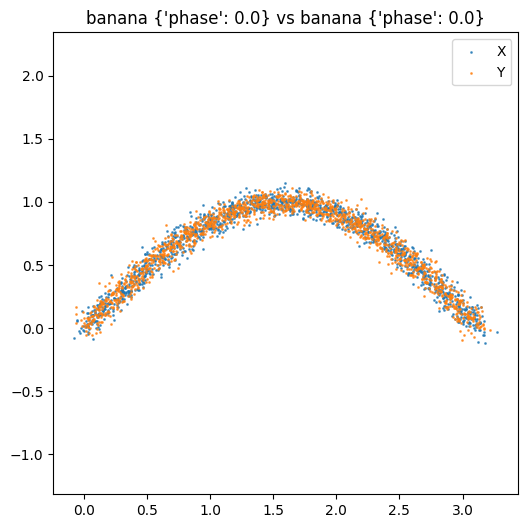

(banana, {'phase': 0.0}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.01302 (time: 0.00s)
   Gromov-Wasserstein:      0.02200093405002669 (time: 3.35s)
   Standard OT:             0.14499970089558972 (time: 0.20s)
   Procrustes OT:           0.14454513726640336 (time: 0.60s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k=  2, t= 0: 0.1449, 0.326s
      k=  2, t= 1: 0.01129, 0.330s
      k=  2, t= 3: 0.01226, 0.357s
      k=  2, t= 5: 0.02569, 0.368s
      k= 10, t= 0: 0.08254, 0.361s
      k= 10, t= 1: 0.02649, 0.362s
      k= 10, t= 3: 0.0159, 0.365s
      k= 10, t= 5: 0.01709, 0.374s
      k=100, t= 0: 0.1073, 0.825s
      k=100, t= 1: 0.137, 0.811s
      k=100, t= 3: 0.01226, 0.734s
      k=100, t= 5: 0.01709, 0.730s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj=  10: 0.009129, 0.000s
      n_proj= 100: 0.009457, 0.019s
      n_proj=1000: 0.009395, 0.065s
      n_proj=5000: 0.009374, 0.402s



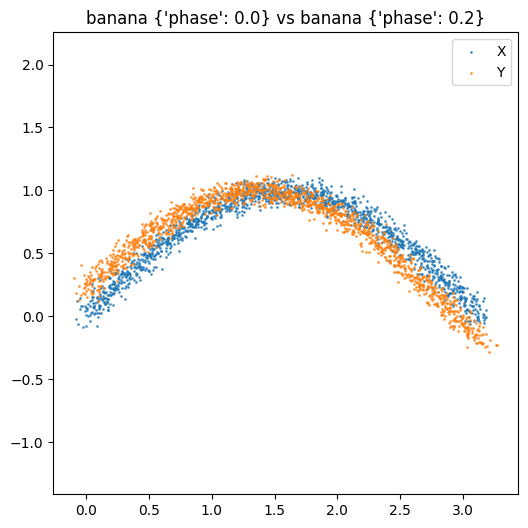

(banana, {'phase': 0.0}) vs (banana, {'phase': 0.2})
   SlicedWasserstein-PCA:   0.05672 (time: 0.00s)
   Gromov-Wasserstein:      0.06000142381719062 (time: 4.04s)
   Standard OT:             0.35854258516915005 (time: 0.22s)
   Procrustes OT:           0.22544330027750684 (time: 1.34s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k=  2, t= 0: 0.07182, 0.333s
      k=  2, t= 1: 0.1613, 0.332s
      k=  2, t= 3: 0.1026, 0.339s
      k=  2, t= 5: 0.1068, 0.348s
      k= 10, t= 0: 0.09, 0.348s
      k= 10, t= 1: 0.08567, 0.353s
      k= 10, t= 3: 0.1152, 0.333s
      k= 10, t= 5: 0.1068, 0.368s
      k=100, t= 0: 0.1063, 0.801s
      k=100, t= 1: 0.08865, 0.827s
      k=100, t= 3: 0.1152, 0.785s
      k=100, t= 5: 0.1068, 0.792s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj=  10: 0.08721, 0.000s
      n_proj= 100: 0.07782, 0.011s
      n_proj=1000: 0.07929, 0.080s
      n_proj=5000: 0.07949, 0.415s



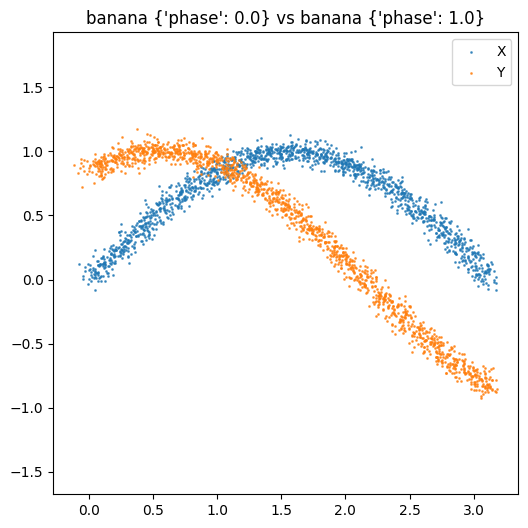

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


(banana, {'phase': 0.0}) vs (banana, {'phase': 1.0})
   SlicedWasserstein-PCA:   0.2562 (time: 0.00s)
   Gromov-Wasserstein:      0.25276343736180085 (time: 4.37s)
   Standard OT:             0.7796111282075328 (time: 0.25s)
   Procrustes OT:           0.5005853328663648 (time: 2.76s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k=  2, t= 0: 0.1457, 0.368s
      k=  2, t= 1: 0.1798, 0.367s
      k=  2, t= 3: 0.2816, 0.357s
      k=  2, t= 5: 0.4408, 0.360s
      k= 10, t= 0: 0.1029, 0.350s
      k= 10, t= 1: 0.1702, 0.394s
      k= 10, t= 3: 0.282, 0.439s
      k= 10, t= 5: 0.4411, 0.433s
      k=100, t= 0: 0.1149, 0.950s
      k=100, t= 1: 0.1797, 1.266s
      k=100, t= 3: 0.282, 0.937s
      k=100, t= 5: 0.4408, 1.096s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj=  10: 0.4649, 0.000s
      n_proj= 100: 0.3754, 0.012s
      n_proj=1000: 0.3867, 0.088s
      n_proj=5000: 0.3885, 0.400s



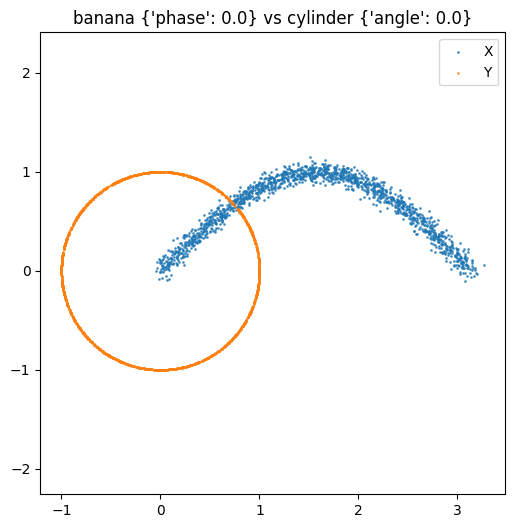

ValueError: shapes (1500,3) and (2,) not aligned: 3 (dim 1) != 2 (dim 0)

In [12]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes
from scipy.sparse.linalg import eigsh
from sklearn import datasets
import itertools
import matplotlib.pyplot as plt
import time

try:
    import ot  # POT: Python Optimal Transport
    has_pot = True
except ImportError:
    print("python-ot (POT) not found, Gromov-Wasserstein/OT comparison disabled")
    has_pot = False

######################
# Embedding Functions #
######################

def pca_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=k if k else X.shape[1])
    pca.fit(Xc)
    return pca.transform(Xc)  # returns n x k array, like diffusion_embedding

# think more about t and symmetric normalization
def diffusion_embedding(X, k=5, epsilon=None, t=1):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    D_sq = cdist(Xc, Xc, 'sqeuclidean')
    if epsilon is None:
        epsilon = np.median(D_sq)
    K = np.exp(-D_sq / epsilon)
    d = np.sum(K, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    P_tilde = D_inv_sqrt @ K @ D_inv_sqrt

    # --- Choose eigensolver automatically ---
    # Full eigendecomposition if k >= n-1
    if k >= n - 1:
        vals, vecs = eigh(P_tilde)
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        # Remove the trivial eigenvector (usually the top one)
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]
    else:
        # Partial: only top k+1
        vals, vecs = eigsh(P_tilde, k=k+1, which='LM')
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]

    embedding_matrix = phis * (lambdas ** t)
    return embedding_matrix


###################################
# Sliced Wasserstein Assignment   #
###################################

def get_sorted_columns(A):
    # A: n x k array
    # Returns: list of length k, each is sorted 1D array of size n
    return [np.sort(A[:, i]) for i in range(A.shape[1])]

# write more general 1D Wasserstein distance
def compute_1d_wasserstein_sorted(u_sorted, v_sorted):
    # Both should be pre-sorted arrays
    return np.mean((u_sorted - v_sorted)**2) # square is built in

def assignment_sliced_wasserstein(X, Y, AX, BY):
    k = AX.shape[1]
    # Precompute and cache sorted columns
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            d_pos = compute_1d_wasserstein_sorted(AX_sorted[i], BY_sorted[j])
            d_neg = compute_1d_wasserstein_sorted(AX_sorted[i], -BY_sorted[j])
            C[i, j] = min(d_pos, d_neg) # square has been done already
    row_ind, col_ind = linear_sum_assignment(C)
    total_cost = C[row_ind, col_ind].sum()
    return np.sqrt(total_cost) # to hopefully be a pseudometric - regardless, matching units

##############################
# Baselines: GW and OT and ...#
##############################

def gromov_wasserstein(X, Y):
    if not has_pot:
        return np.nan
    C1 = cdist(X, X)  # pairwise distance matrix for X
    C2 = cdist(Y, Y)  # pairwise distance matrix for Y
    # we assume uniform distributions for both sets
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    # GW returns the cost directly (not the coupling)
    gw_cost = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return np.sqrt(gw_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent


def standard_ot(X, Y):
    if not has_pot:
        return np.nan
    # same deal as GW
    C = cdist(X, Y)
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    T = ot.emd(p, q, C, numItermax=10000000)
    ot_cost = (C * T).sum()
    return np.sqrt(ot_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent

def orthogonal_procrustes_matching(X, Y, max_iter=100, tol=1e-6, verbose=False):
    """
    Find the best orthogonal R (no scaling) and permutation π so that Xc ≈ (Yc @ R)[π].
    Returns the sum of squared distances under that R + π.
    """
    # 1) center both clouds
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    n, d = Xc.shape

    # 2) start with the identity matching
    π = np.arange(n)
    cost_prev = np.inf

    for it in range(max_iter):
        # ─── Step 1: find the orthogonal rotation R (no scale) that best aligns Yc[π] → Xc ───
        R, _ = orthogonal_procrustes(Yc[π], Xc)
        Yc_rot = Yc @ R   # *** drop any scale ***

        # ─── Step 2: re‐compute the one‐to‐one assignment under the new rotation ───
        C = cdist(Xc, Yc_rot, metric='sqeuclidean')
        row_ind, col_ind = linear_sum_assignment(C)
        cost = C[row_ind, col_ind].sum()

        if verbose:
            print(f"Iter {it}: cost = {cost:.8f}")

        # check convergence
        if abs(cost - cost_prev) < tol:
            break

        cost_prev = cost
        π = col_ind

    # ─── Final transform (pure rotation + centroid shift) ───
    R, _ = orthogonal_procrustes(Yc[π], Xc)
    Yc_aligned = Yc @ R
    # add back X’s centroid
    Y_aligned = Yc_aligned + X.mean(axis=0)

    return cost, (Y_aligned, R, π)


def procrustes_ot(X, Y):
    if not has_pot:
        return np.nan
    cost, (Y_aligned, R, pi) = orthogonal_procrustes_matching(X, Y)
    # Now you can compare X and Y_aligned, or run OT/GW/etc.
    # For vanilla OT cost:
    return standard_ot(X, Y_aligned)

def sliced_wasserstein(X, Y, n_proj=100, p=2, seed=None):
    """
    Standard Sliced Wasserstein (squared Wp, default W2):
      - Projects onto random unit vectors
      - Computes 1D Wasserstein between projections
      - Returns the mean distance across all projections (root if p=2)
    """
    rng = np.random.default_rng(seed)
    n, d = X.shape
    m = Y.shape[0]
    dists = []
    for _ in range(n_proj):
        v = rng.normal(size=d)
        v /= np.linalg.norm(v)  # unit vector

        # Project onto v
        X_proj = np.dot(X, v)
        Y_proj = np.dot(Y, v)

        # Sort and compute 1D Wasserstein-p distance
        X_proj_sorted = np.sort(X_proj)
        Y_proj_sorted = np.sort(Y_proj)
        # Need equal sizes for empirical distributions: subsample or interpolate if needed
        n_used = min(len(X_proj_sorted), len(Y_proj_sorted))
        Xs = X_proj_sorted[:n_used]
        Ys = Y_proj_sorted[:n_used]
        dist = np.mean(np.abs(Xs - Ys) ** p)
        dists.append(dist)

    return np.mean(dists)**(1/p)




########################
# Synthetic Datasets   #
########################

def generate_dataset(kind, n=100, d=2, mean=None, cov=None, angle=None, phase=None):
    if kind == 'normal':
        m = mean if mean is not None else np.zeros(d)
        c = cov if cov is not None else np.eye(d)
        X = np.random.multivariate_normal(m, c, n)
        return X
    elif kind == 'banana':
        t = np.linspace(0, np.pi, n)
        phi = phase if phase is not None else 0.0
        X = np.vstack([t, np.sin(t + phi)]).T + 0.05 * np.random.randn(n, 2)
        return X
    elif kind == 'cylinder':
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-1, 1, n)
        ang = angle if angle is not None else 0.0
        X = np.vstack([np.cos(theta + ang), np.sin(theta + ang), z]).T
        return X
    elif kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        return X[:, :d]
    else:
        raise ValueError('Unknown dataset kind')

def plot_pair(X, Y, title=None, savepath=None):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], s=1, label='X', alpha=0.7)
    plt.scatter(Y[:,0], Y[:,1], s=1, label='Y', alpha=0.7)
    plt.axis('equal')
    plt.legend()
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

##########################################################
# Dataset parameterizations to try (expand as desired)   #
##########################################################

DATASET_PARAMS = {
    'banana': [
        dict(phase=0.0), 
        dict(phase=0.2),
        dict(phase=1.0),
    ],
    'cylinder': [
        dict(angle=0.0), 
        dict(angle=0.2),
        dict(angle=np.pi/2),
    ],
    'normal': [
        dict(mean=np.zeros(2)), 
        dict(mean=np.ones(2)), 
        dict(mean=np.array([2.0, -2.0])),
        dict(mean=np.zeros(2), cov=np.diag([1, 4])),
        dict(mean=np.zeros(2), cov=2*np.eye(2)),
        dict(mean=np.zeros(2), angle=np.pi/4),  # for rotation
    ],
    'swissroll': [
        dict(),  # no params
    ]
}

########################################
# Cartesian Product of Tests Framework #
########################################

def test_diffusion_grid(X, Y, k_values, t_values, distance_fn):
    results = {}
    for k in k_values:
        for t in t_values:
            t0 = time.time()
            AX = diffusion_embedding(X, k=k, t=t)
            BY = diffusion_embedding(Y, k=k, t=t)
            # Optionally rescale to match variance for fair distance comparison
            scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
            AX *= scale
            BY *= scale
            dist = distance_fn(X, Y, AX, BY)
            t1 = time.time()
            results[(k, t)] = (dist, t1 - t0)
    return results

def test_sliced_wasserstein_proj(X, Y, n_proj_values, seed=None):
    results = {}
    for n_proj in n_proj_values:
        t0 = time.time()
        dist = sliced_wasserstein(X, Y, n_proj=n_proj, p=2, seed=seed)
        t1 = time.time()
        results[n_proj] = (dist, t1 - t0)
    return results

def test_framework():
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))

    # Grid parameters
    k_values = [2, 10, 100]
    t_values = [0, 1, 3, 5]
    n_proj_values = [10, 100, 1000, 5000]

    print("Pairwise tests (cartesian product):\n")
    for (dtype1, p1), (dtype2, p2) in itertools.product(configs, configs):
        n = 1500
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        Y = generate_dataset(dtype2, n=n, d=2, **p2)
        plot_pair(X, Y, title=f'{dtype1} {p1} vs {dtype2} {p2}', savepath=None)
        k = min(X.shape[1], Y.shape[1])

        # PCA embedding baseline
        t0 = time.time()
        AX = pca_embedding(X, k)
        BY = pca_embedding(Y, k)
        d_pca = assignment_sliced_wasserstein(X, Y, AX, BY)
        t1 = time.time()
        pca_time = t1 - t0

        # Diffusion embedding grid (k, t)
        diffusion_results = test_diffusion_grid(
            X, Y, k_values=k_values, t_values=t_values,
            distance_fn=assignment_sliced_wasserstein
        )

        # Sliced Wasserstein with varying n_proj (standard)
        sw_proj_results = test_sliced_wasserstein_proj(
            X, Y, n_proj_values=n_proj_values, seed=42
        )

        # GW, OT, Procrustes
        t0 = time.time()
        d_gw = gromov_wasserstein(X, Y)
        t1 = time.time()
        gw_time = t1 - t0

        t0 = time.time()
        d_ot = standard_ot(X, Y)
        t1 = time.time()
        ot_time = t1 - t0

        t0 = time.time()
        d_proc = procrustes_ot(X, Y)
        t1 = time.time()
        procrustes_time = t1 - t0

        print(f'({dtype1}, {p1}) vs ({dtype2}, {p2})')
        print(f'   SlicedWasserstein-PCA:   {d_pca:.4g} (time: {pca_time:.2f}s)')
        print(f'   Gromov-Wasserstein:      {d_gw} (time: {gw_time:.2f}s)')
        print(f'   Standard OT:             {d_ot} (time: {ot_time:.2f}s)')
        print(f'   Procrustes OT:           {d_proc} (time: {procrustes_time:.2f}s)')
        print('   --- Diffusion grid (assignment SlicedWasserstein) ---')
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            print(f'      k={kk:3d}, t={tt:2d}: {dist:.4g}, {t_elapsed:.3f}s')
        print('   --- Standard Sliced Wasserstein by n_proj ---')
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            print(f'      n_proj={n_proj:4d}: {dist:.4g}, {t_elapsed:.3f}s')
        print()

if __name__ == '__main__':
    test_framework()